# What Makes a Successful Stock Portfolio?

## Background

Building a high-performing portfolio is every investor's goal. However, there does not seem to be a consensus on how best to do this. Some people are paid large amounts of money to figure out how to optimize portfolios, but for the every-day investor, this type of time-consuming and highly technical analysis is not feasible. Therefore, it is of interest to us to try to find the best indicators of a good portfolio. For this purpose, we will be using a dataset of simulated stock portfolios provided by Chung Hua University and Tamkang University, both in Taiwan. The dataset gives weights, on a scale of 0 to 1, to each of six stock-picking concepts, based on the overall strategy of the portfolio. The creators of this dataset use the S&P 500 index as a way to measure the performance of the simulated portfolios, so it is safe to assume that the portfolios pick American stocks (i.e. traded on NYSE, NASDAQ, etc.). The simulations cover 20 years (9/30/1990 - 6/30/2010), or 80 quarters, and average out the returns over that time span. This covers both economic expansions and recessions, so the portfolios should be fairly robust.

The main stock-picking concepts simulated here are as follows:
* B/P Ratio: a way to compare the book value of the underlying business to the current market price
* ROE: measure of financial performance of the business (return on equity)
* S/P Ratio: a way to compare the revenues of the underlying business to the current stock price
* Return Rate in Last Quarter
* Market Value
* Systematic Risk (volatility)

### A Word of Caution
Before we move on, it is important to note that these are _simulated_ portfolios as opposed to _actual_ portfolios. As such, we don't know what the underlying stock choices were for any of them, how many stocks each portfolio included, or how much money each portfolio started with. However, even if we were to use actual stock portfolios from mutual funds or ETFs, we wouldn't know the underlying stock-picking strategy behind them (if fund managers told us their strategies they'd be out of jobs). What we have seems like the better option, since an actual strategy is arguably more valuable than the stock picks themselves. 

Also of note is that the strategies discussed here are only a few of potentially thousands of strategies. Don't think of this as a definitive solution, but instead a good starting point. Since the simulations only run through 2010, the strategies outlined here may not even be viable anymore. 

In [3]:
# import all necessary packages
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline

In [4]:
df = pd.read_excel('~/Downloads/stock_portfolio_performance.xlsx', sheet_name='all period', skiprows=1, index_col='ID')

## First Glance at the Data
The first thing we want to do is take a look at the data we're dealing with. In general, we want to know:
* What kind of returns are these portfolios delivering?
* What kind of win rates do these portfolios have (what proportion of stocks make money as opposed to lose money)?

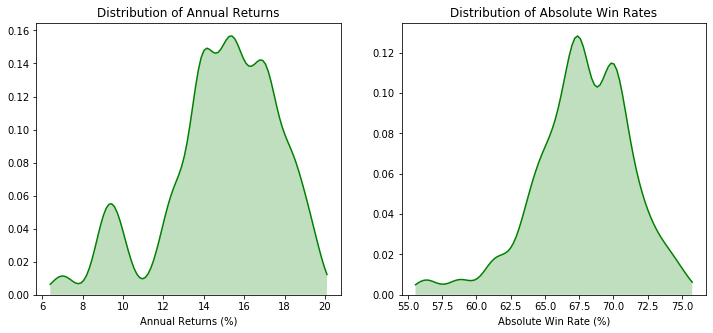

In [8]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.kdeplot(df['Annual Return (%)']*100, color='green', shade=True, bw=.20, legend=False)
plt.title("Distribution of Annual Returns")
plt.xlabel("Annual Returns (%)")

plt.subplot(1, 2, 2)
sns.kdeplot(df['Abs. Win Rate (%)']*100, color='green', shade=True, bw=.25, legend=False)
plt.title("Distribution of Absolute Win Rates")
plt.xlabel("Absolute Win Rate (%)")
plt.show()

The graphs above show that both returns and absolute win rates have left-skewed distributions. The annual returns of the portfolios seem to have a major cluster around 14% to 18%, and a smaller cluster around 9%. Portfolio win rates, on the other hand, seem to cluster around 67%-70%.

## Does Risk Equal Reward?
It's become a cliche that risk = reward in the finance world. However, is this actually true? In order to find out we can compare the average returns of each portfolio to the systematic risk involved.

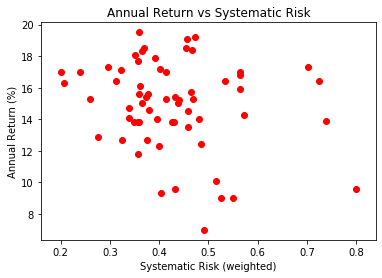

In [9]:
plt.scatter(x=df['Systematic Risk'], y=df['Annual Return (%)']*100, color='red')
plt.title("Annual Return vs Systematic Risk")
plt.xlabel("Systematic Risk (weighted)")
plt.ylabel("Annual Return (%)")
plt.show()

On first glance, it doesn't look like there is a strong correlation between risk and returns. Our chart almost resembles a cloud of data points, but we can barely make out a negative correlation. That is, there seems to be a slight, downward slope from left to right. This suggests that outsize risk may, in fact, hurt returns overall. 

## Which Factors Should We Care About?

Since we now know that risk does not definitively equal reward, we should take a look at the six main stock-picking methods that form each portfolio's strategy. As mentioned above, each factor is given a relative weight from 0 to 1. Looking at the dataset, we can see that the weights vary based on predetermined splits. For example, one extreme has all weight on one method; the other extreme has equal weight on all methods. Thus, the weights are given as one of seven distinct possibilities: 1.000, 0.500, 0.333, 0.250, 0.200 0.167, and 0. We can therefore convert the weights into categorical values for our exploratory analysis.

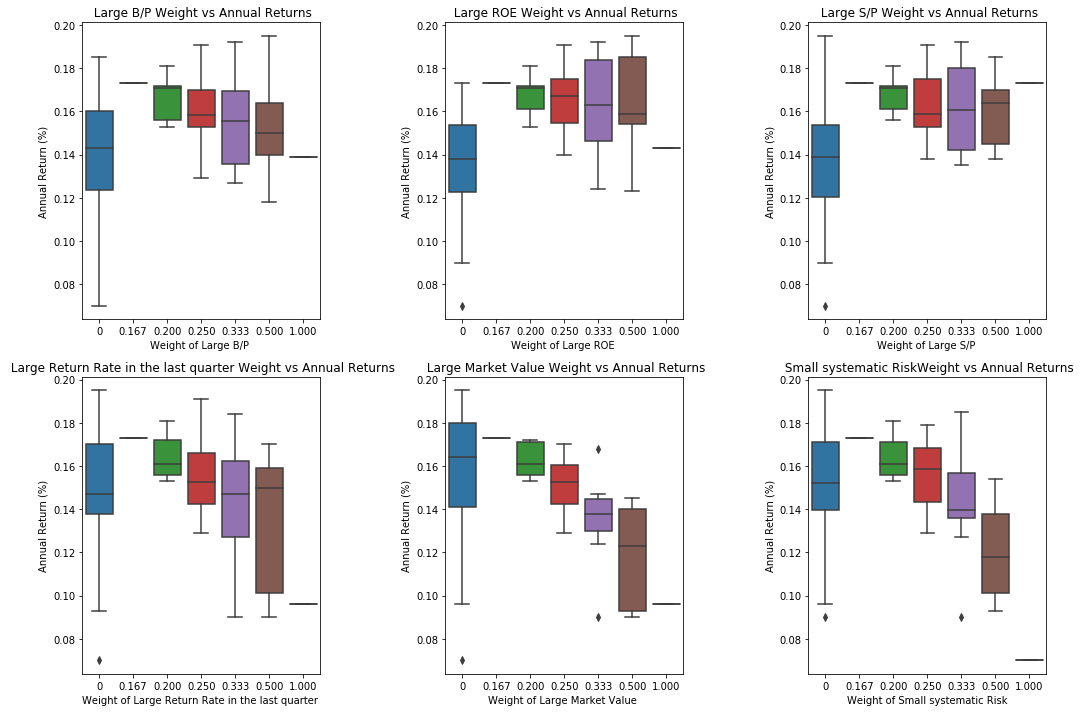

In [10]:
df_cats = df
plt.figure(figsize=(15,10))
for i, factor in enumerate(df_cats.columns.values.tolist()[:6]):
    df_cats[factor] = df_cats[factor].astype('category')
    
    plt.subplot(2, 3, i+1)
    returns_df = []
    for weight in sorted(list(set(df_cats[factor]))):
        temp_df = df_cats[df_cats[factor] == weight]
        returns_df.append(temp_df["Annual Return (%)"])
    sns.boxplot(data=returns_df)
    plt.title("{}Weight vs Annual Returns".format(factor))
    plt.xlabel("Weight of{}".format(factor))
    plt.xticks([0, 1, 2, 3, 4, 5, 6], ['0', '0.167', '0.200', '0.250', '0.333', '0.500', '1.000'])
    plt.ylabel("Annual Return (%)")
    
plt.tight_layout()
plt.show()

The above graph illuminates some interesting findings. Firstly, none of the strategies in which only a single stock-picking method was used performed the best. Second, there seems to be a clear hierarchy to the effectiveness of the stock-picking methods. In terms of single-method strategies, picking stocks based solely on systematic risk proved to be the worst (this was the overall worst strategy as well). Picking based on previous return rate and market value fared just as well as each other, but still came out towards the bottom of the pack. Next, picking based on B/P ratio and ROE gave almost equivalent returns. The best single-method strategy was based on S/P ratio.

Interestingly, even though the B/P and ROE methods themselves were middle-of-the-pack performers, their combined strategy yielded the best strategy overall, with nearly 20% returns. We can see this in their individual 0.500-weight box plots, which are the only two that reach up towards 20% (this is confirmed by the other methods' high-reaching 0-weight boxplots). The 0.333-, 0.250-, and 0.200-weighted boxplots all seem to have fairly similar spreads of returns, but we can see that 0.500-weighted strategies that incorporated the B/P, ROE, or S/P stock-picking methods did better on average than those strategies that incorporated the return rate, market value, or systematic risk stock-picking methods. 

## What Were the Best Performing Portfolios?

Now that we know B/P, ROE, and S/P are more effective stock-picking methods, we can see how the weightings of each stock-picking methodology correlates with annual returns, using a heatmap as a visual representation.

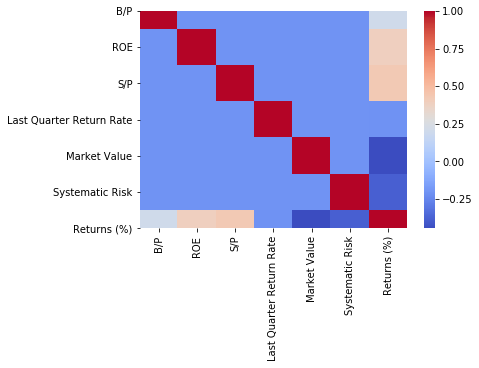

In [12]:
weightings = df.iloc[:,0:7].copy()
weightings = np.float64(weightings) # data is not of the proper type
weightings = pd.DataFrame(weightings) # convert back to dataframe 
weightings.columns = ['B/P', 'ROE', 'S/P', 'Last Quarter Return Rate', 'Market Value', 'Systematic Risk', 'Returns (%)']
sns.heatmap(weightings.corr(), cmap='coolwarm')
plt.show()

The above heatmap gives us visual confirmation that the stock-picking methods based on B/P, ROE, and S/P correlate most with higher annual returns. Stock picking methods based on previous return rates, market value, and systematic risk correlated very poorly with higher annual returns. Now we can look at the top portfolios to see exactly which methods were incorporated and at which weights. For our purposes, we can define the top portfolios as those returning 18% or more annually. This works out to the top 8 portfolios; not too many that it will muddle the analysis, and not too few that we cannot find meaningful insights.

In [13]:
top_portfolios = df[df["Annual Return (%)"]*100 >= 18.0]
top_portfolios

,Large B/P,Large ROE,Large S/P,Large Return Rate in the last quarter,Large Market Value,Small systematic Risk,Annual Return (%),Excess Return (%),Systematic Risk (%),Total Risk (%),Abs. Win Rate (%),Rel. Win Rate (%),Annual Return,Excess Return,Systematic Risk,Total Risk,Abs. Win Rate,Rel. Win Rate
ID,,,,,,,,,,,,,,,,,,
7,0.500,0.500,0.000,0.000,0.0,0.000,0.195,0.026,0.97,0.105,0.738,0.638,0.800000,0.800000,0.359752,0.375191,0.76,0.729412
9,0.000,0.500,0.500,0.000,0.0,0.000,0.185,0.022,1.06,0.109,0.675,0.650,0.750621,0.721140,0.454210,0.418338,0.56,0.764706
22,0.333,0.333,0.333,0.000,0.0,0.000,0.192,0.024,1.08,0.117,0.700,0.650,0.786064,0.760358,0.472136,0.491762,0.64,0.764706
23,0.333,0.333,0.000,0.333,0.0,0.000,0.183,0.023,0.98,0.102,0.725,0.575,0.740120,0.739476,0.365403,0.354656,0.72,0.552941
25,0.000,0.333,0.333,0.333,0.0,0.000,0.184,0.022,1.07,0.109,0.700,0.613,0.746929,0.712063,0.467069,0.414118,0.64,0.658824
34,0.000,0.333,0.333,0.000,0.0,0.333,0.185,0.024,0.98,0.105,0.675,0.588,0.753438,0.754758,0.368576,0.377268,0.56,0.588235
42,0.250,0.250,0.250,0.250,0.0,0.000,0.191,0.024,1.06,0.113,0.700,0.575,0.780418,0.752834,0.456870,0.457240,0.64,0.552941
58,0.200,0.200,0.200,0.200,0.0,0.200,0.181,0.023,0.96,0.105,0.675,0.575,0.730448,0.743605,0.350473,0.379353,0.56,0.552941


As we can see in the resulting data frame, the absolute best performing portfolio was in fact the one that split weight evenly between the B/P and ROE stock-picking methods (19.5% average returns), confirming our assertion from the boxplots. We can also see that at least two of the B/P, ROE, and S/P methods showed up in all of the top performing portfolios. The worst performing portfolio in this group was the only one to incorporate more than one of the bottom three stock-picking methods (in this case, rate of return and systematic risk). This further solidifies the hierarchy we established earlier. 

We can also now confirm whether or not risk really equals reward.

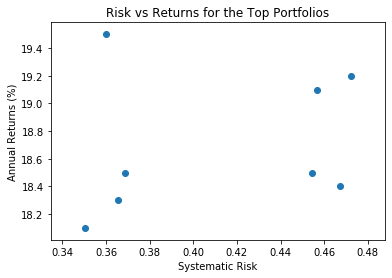

In [14]:
plt.scatter(top_portfolios['Systematic Risk'], top_portfolios['Annual Return (%)']*100)
plt.title("Risk vs Returns for the Top Portfolios")
plt.ylabel("Annual Returns (%)")
plt.xlabel("Systematic Risk")
plt.show()

The graph above confirms that there is no real correlation between risk and returns. However, we can compare the mean risk of the top portfolios to that of the others and see if there is a sweet spot.

In [15]:
other_portfolios = pd.concat([df, top_portfolios, top_portfolios]).drop_duplicates(keep=False)

In [16]:
print("Mean risk of top portfolios: {}".format(top_portfolios["Systematic Risk"].mean()))
print("Mean risk of other portfolios: {}".format(other_portfolios["Systematic Risk"].mean()))

Mean risk of top portfolios: 0.4118112146185705
Mean risk of other portfolios: 0.4286293508746614


There does not seem to be a significant difference in systematic risk between the top portfolios and the other portfolios, further solidifying our assertion against higher risk leading to higher returns. 

Now we can formalize our findings by calculating certain ratios that are widely used in determining the risk/reward relationship in each portfolio. Namely, we will calculate the Sharpe Ratio, Treynor Ratio, and Jensen's Alpha for each of the top portfolios. For our purposes, and since the returns of the portfolios span a 20-year period, we will assume that the market return was 10%, and that the risk-free rate, taken as the rate of return of 10-year Federal bond notes, was 5%.

In [21]:
import warnings
warnings.filterwarnings("ignore")

top_portfolios['Sharpe Ratio'] = (top_portfolios['Annual Return (%)'] - 0.05) / top_portfolios['Total Risk (%)']
top_portfolios['Treynor Ratio'] = (top_portfolios['Annual Return (%)'] - 0.05) / top_portfolios['Systematic Risk (%)']
top_portfolios['CAPM'] = 0.05 + top_portfolios['Systematic Risk (%)'] * (0.10 - 0.05)
top_portfolios['Jensen Alpha'] = top_portfolios['Annual Return (%)'] - top_portfolios['CAPM']
perf_metrics = top_portfolios[['Annual Return (%)', 'Sharpe Ratio', 'Treynor Ratio', 'CAPM', 'Jensen Alpha']]
perf_metrics

,Annual Return (%),Sharpe Ratio,Treynor Ratio,CAPM,Jensen Alpha
ID,,,,,
7,0.195,1.380952,0.149485,0.0985,0.0965
9,0.185,1.238532,0.127358,0.1030,0.0820
22,0.192,1.213675,0.131481,0.1040,0.0880
23,0.183,1.303922,0.135714,0.0990,0.0840
25,0.184,1.229358,0.125234,0.1035,0.0805
34,0.185,1.285714,0.137755,0.0990,0.0860
42,0.191,1.247788,0.133019,0.1030,0.0880
58,0.181,1.247619,0.136458,0.0980,0.0830


As we can see above, Portfolio 7 (equal weighting between B/P Ratio and ROE methods) had both the best Sharpe ratio and the best Treynor ratio. The Jensen Alpha of Portfolio 7 was also significantly higher than those of the other portfolios. This is because that portfolio had the second-lowest expected return (CAPM) of all the portfolios. The data here once again shows that investing in riskier assets does not necessarily result in greater gains. Even on a risk adjusted basis, the riskier portfolios underperformed. 

Additionally, the two methods used in our top portfolio can be considered value investing-oriented. B/P ratio is the inverse of P/B ratio, one of the most used ratios when determining which companies are trading at a discount to their worth. The idea is that all else being equal, companies priced low when compared to the book value of the enterprise are in fact priced below fair value - they can then be expected to eventually return to fair value, thus outperforming the overall market (which is always at fair value). ROE, as mentioned earlier, is a business performance metric. Companies with high ROE are considered to be operating with high efficiency. It can be calculated by dividing the net income of the enterprise by the total shareholders' equity. If the management of the enterprise is operating with efficiency, it may be expected to then outperform the market.

Of further note is that the previous-return-rate and market-value stock picking methods can be considered as momentum-investing oriented. The operating assumptions are that stocks that have performed well in the past will continue to perform well, and that large companies will continue to grow. Thus, stocks picked under these two strategies should continue to experience growth. However, as the data shows, that is not the case.

## Conclusions

The main conclusion we can draw is one that has been hammered into us throughout this exploration: that for an overall portfolio, risk does not necessarily equal reward. In fact, there seems to be a bit of a sweet spot. Portfolios that gave high weighting to picking stocks based on small systematic risk actually did poorer overall (see the boxplot and heatmap) which suggests that not taking enough risk can also hurt long-term rewards. 

If you wanted the absolute best-performing portfolio, you would have one that gave equal weight to picking stocks based on large B/P ratio and large ROE. If you only wanted to focus on a single strategy, then picking stocks based on large S/P ratio is your best bet. 

Naturally, the analysis we performed here is limited. The portfolios are only simulated, and the number of stock-picking strategies in the real world is as varied as the people on Wall Street. The best of the best will likely never give the exact formulas they use to pick stocks, but with a more robust analysis, we may be able to hone in on a few strategies that on average perform better than others. There's no reason that only a few big-shots should know the secret to good investing.